<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


<h1><center>Final Assignment</center></h1>


> ***Note: Please ensure you follow the instructions outlined in the in the <a href="https://www.coursera.org/learn/supervised-machine-learning-regression/supplement/YGZt9/project-scenario">Project Scenario</a> section to complete this Final Assignment successfully.***


# Step 1 — Setup, Load CMAPSS FD001, Build RUL Labels, and Summarize Data

In [9]:
# %% 
# Imports & config
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from pathlib import Path

pd.set_option("display.max_columns", 200)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# %%
# Helper: find files under /kaggle/input (and fallback to working dir if needed)
def find_file(pattern):
    candidates = glob.glob(f"/kaggle/input/**/{pattern}", recursive=True)
    if not candidates:
        candidates = glob.glob(f"/kaggle/working/**/{pattern}", recursive=True) + glob.glob(pattern)
    assert len(candidates) >= 1, f"File not found for pattern: {pattern}"
    return sorted(candidates, key=lambda p: len(p))[0]

train_path = find_file("train_FD001.txt")
test_path  = find_file("test_FD001.txt")
rul_path   = find_file("RUL_FD001.txt")

train_path, test_path, rul_path

# %%
# Load files
# FD001 has: 3 operational settings + 21 sensors
col_names = (
    ["unit", "cycle", "setting1", "setting2", "setting3"] +
    [f"s{i}" for i in range(1, 22)]
)

train = pd.read_csv(train_path, sep=r"\s+", header=None, names=col_names)
test  = pd.read_csv(test_path,  sep=r"\s+", header=None, names=col_names)
rul   = pd.read_csv(rul_path,   sep=r"\s+", header=None, names=["RUL"])

display(train.head(3))
display(test.head(3))
display(rul.head())



,unit,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442


,unit,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.2,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.5,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.5,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166


,RUL
0,112
1,98
2,69
3,82
4,91


In [10]:
# %%
# Construct RUL for TRAIN
# For each unit, failure occurs at its last recorded cycle; RUL = max_cycle(unit) - cycle
train_max_cycle = train.groupby("unit")["cycle"].transform("max")
train["RUL"] = (train_max_cycle - train["cycle"]).astype(float)

# Construct RUL for TEST
# RUL_FD001 gives the remaining life at the LAST cycle of each test unit.
# For any row (unit u, cycle c):
#   true_RUL = (max_cycle_u - c) + RUL_at_last_cycle(u)
test_max_by_unit = test.groupby("unit")["cycle"].transform("max")

test_units_sorted = np.sort(test["unit"].unique())
assert len(test_units_sorted) == len(rul), "Mismatch: #test units vs #rows in RUL_FD001.txt"

rul_map = pd.Series(rul["RUL"].values, index=test_units_sorted)  # unit -> RUL at last cycle
test["RUL"] = (test_max_by_unit - test["cycle"]).astype(float) + test["unit"].map(rul_map).astype(float)

# Quick integrity checks
assert train["RUL"].min() == 0.0, "Train RUL should reach 0 at failures."
assert (test.groupby("unit").apply(lambda df: df.loc[df["cycle"].idxmax(), "RUL"]).values == rul["RUL"].values).all(), \
       "Test last-cycle RUL should match RUL_FD001."

# %%
# Basic hygiene: identify zero-variance columns (by TRAIN only)
feature_cols_all = [c for c in train.columns if c not in ["unit", "cycle", "RUL"]]
zero_var = train[feature_cols_all].std(axis=0) <= 1e-8
zero_var_cols = list(zero_var[zero_var].index)
kept_cols = [c for c in feature_cols_all if c not in zero_var_cols]

print("Zero-variance columns (train):", zero_var_cols)
print("Kept feature columns (count={}): {}".format(len(kept_cols), kept_cols[:10] + (["..."] if len(kept_cols)>10 else [])))

# %%
# === Data Summary for Report ===
def summarize_df(df, name):
    n_units = df["unit"].nunique()
    n_rows  = len(df)
    n_feats = len([c for c in df.columns if c not in ["unit", "cycle", "RUL"]])
    cycles_per_unit = df.groupby("unit")["cycle"].max().describe()
    summary = {
        "Dataset": name,
        "Rows": n_rows,
        "Units": n_units,
        "Features (settings+ sensors)": n_feats,  # 3 settings + 21 sensors (less any zero-variance)
        "Min last cycle per unit": int(cycles_per_unit["min"]),
        "Median last cycle per unit": int(cycles_per_unit["50%"]),
        "Max last cycle per unit": int(cycles_per_unit["max"]),
        "Target": "RUL (Remaining Useful Life) per cycle"
    }
    return summary

train_summary = summarize_df(train, "Train FD001")
test_summary  = summarize_df(test,  "Test FD001")

print("=== Data Summary ===")
for k, v in train_summary.items():
    print(f"{k}: {v}")
print("-"*40)
for k, v in test_summary.items():
    print(f"{k}: {v}")

# Missing values check
print("\nMissing values (train):", int(train.isna().sum().sum()))
print("Missing values (test):", int(test.isna().sum().sum()))



Zero-variance columns (train): ['setting3', 's1', 's5', 's10', 's16', 's18', 's19']
Kept feature columns (count=17): ['setting1', 'setting2', 's2', 's3', 's4', 's6', 's7', 's8', 's9', 's11', '...']
=== Data Summary ===
Dataset: Train FD001
Rows: 20631
Units: 100
Features (settings+ sensors): 24
Min last cycle per unit: 128
Median last cycle per unit: 199
Max last cycle per unit: 362
Target: RUL (Remaining Useful Life) per cycle
----------------------------------------
Dataset: Test FD001
Rows: 13096
Units: 100
Features (settings+ sensors): 24
Min last cycle per unit: 31
Median last cycle per unit: 133
Max last cycle per unit: 303
Target: RUL (Remaining Useful Life) per cycle

Missing values (train): 0
Missing values (test): 0


/tmp/ipykernel_36/2244778143.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  assert (test.groupby("unit").apply(lambda df: df.loc[df["cycle"].idxmax(), "RUL"]).values == rul["RUL"].values).all(), \


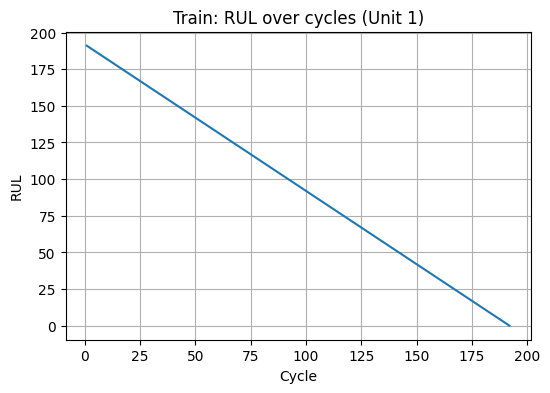

/tmp/ipykernel_36/1812275824.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_last_cycle_rul = test.groupby("unit").apply(lambda d: d.loc[d["cycle"].idxmax(), "RUL"])


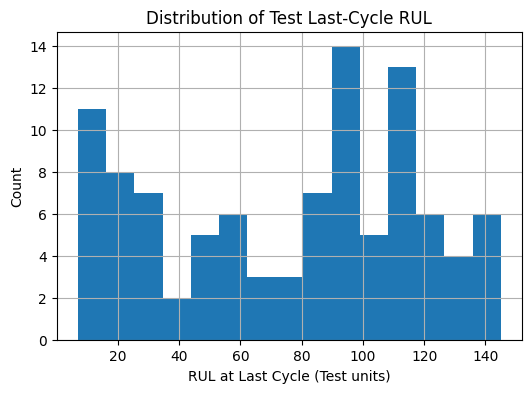

In [11]:
# %%
# Optional quick visuals for intuition (safe to skip if you want text-only)
# 1) Example unit trajectory: cycle vs RUL
example_unit = train["unit"].iloc[0]
ex_df = train[train["unit"] == example_unit].sort_values("cycle")

plt.figure(figsize=(6,4))
plt.plot(ex_df["cycle"], ex_df["RUL"])
plt.xlabel("Cycle")
plt.ylabel("RUL")
plt.title(f"Train: RUL over cycles (Unit {example_unit})")
plt.grid(True)
plt.show()

# 2) Distribution of last-cycle RUL in the TEST set (these come from RUL_FD001)
test_last_cycle_rul = test.groupby("unit").apply(lambda d: d.loc[d["cycle"].idxmax(), "RUL"])
plt.figure(figsize=(6,4))
plt.hist(test_last_cycle_rul.values, bins=15)
plt.xlabel("RUL at Last Cycle (Test units)")
plt.ylabel("Count")
plt.title("Distribution of Test Last-Cycle RUL")
plt.grid(True)
plt.show()


In [12]:
# %%
# Auto-fill the template above with concrete numbers for easy copy-paste
train_rows  = len(train)
train_units = train["unit"].nunique()
test_rows   = len(test)
test_units  = test["unit"].nunique()
desc = train.groupby("unit")["cycle"].max().describe()
min_c, med_c, max_c = int(desc["min"]), int(desc["50%"]), int(desc["max"])

print(f"""
Data Summary: We used NASA CMAPSS turbofan engine dataset (FD001) comprising multivariate time-series with 3 operational settings and 21 sensors. After constructing Remaining Useful Life (RUL) per cycle, the train split contains {train_rows:,} rows across {train_units} units, and the test split contains {test_rows:,} rows across {test_units} units. Per-unit life ranges from {min_c} to {max_c} cycles (median {med_c}). No missing values were detected. The target variable is RUL.
""".strip())


Data Summary: We used NASA CMAPSS turbofan engine dataset (FD001) comprising multivariate time-series with 3 operational settings and 21 sensors. After constructing Remaining Useful Life (RUL) per cycle, the train split contains 20,631 rows across 100 units, and the test split contains 13,096 rows across 100 units. Per-unit life ranges from 128 to 362 cycles (median 199). No missing values were detected. The target variable is RUL.


# # Step 2 — Feature Hygiene & Cross-Validation Setup


In [13]:
# %%
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# At this point, `train` and `test` are already available from Step 1
print(train.head(2))
print(test.head(2))


   unit  cycle  setting1  setting2  setting3      s1      s2       s3  \
0     1      1   -0.0007   -0.0004     100.0  518.67  641.82  1589.70   
1     1      2    0.0019   -0.0003     100.0  518.67  642.15  1591.82   

        s4     s5     s6      s7       s8       s9  s10    s11     s12  \
0  1400.60  14.62  21.61  554.36  2388.06  9046.19  1.3  47.47  521.66   
1  1403.14  14.62  21.61  553.75  2388.04  9044.07  1.3  47.49  522.28   

       s13      s14     s15   s16  s17   s18    s19    s20      s21    RUL  
0  2388.02  8138.62  8.4195  0.03  392  2388  100.0  39.06  23.4190  191.0  
1  2388.07  8131.49  8.4318  0.03  392  2388  100.0  39.00  23.4236  190.0  
   unit  cycle  setting1  setting2  setting3      s1      s2       s3  \
0     1      1    0.0023    0.0003     100.0  518.67  643.02  1585.29   
1     1      2   -0.0027   -0.0003     100.0  518.67  641.71  1588.45   

        s4     s5     s6      s7       s8       s9  s10   s11     s12  \
0  1398.21  14.62  21.61  553.90 

In [14]:
# %%
# Identify raw feature columns (exclude identifiers and target)
raw_feature_cols = [c for c in train.columns if c not in ["unit", "cycle", "RUL"]]

# Drop zero-variance columns (computed on TRAIN only)
stds = train[raw_feature_cols].std(axis=0)
zero_var_cols = list(stds[stds <= 1e-8].index)
kept_cols = [c for c in raw_feature_cols if c not in zero_var_cols]

print(f"Dropped zero-variance columns: {zero_var_cols}")
print(f"Kept {len(kept_cols)} features: {kept_cols[:10]}{' ...' if len(kept_cols)>10 else ''}")


Dropped zero-variance columns: ['setting3', 's1', 's5', 's10', 's16', 's18', 's19']
Kept 17 features: ['setting1', 'setting2', 's2', 's3', 's4', 's6', 's7', 's8', 's9', 's11'] ...


In [15]:
# %%
# Build matrices
X_train = train[kept_cols].copy()
y_train = train["RUL"].astype(float).copy()
groups_train = train["unit"].values  # grouping key for GroupKFold

X_test = test[kept_cols].copy()
y_test = test["RUL"].astype(float).copy()

print("Shapes → X_train:", X_train.shape, "| y_train:", y_train.shape)
print("Shapes → X_test :", X_test.shape,  "| y_test :", y_test.shape)

# %%
# Define evaluation scorers
rmse_scorer = make_scorer(lambda y, yhat: mean_squared_error(y, yhat, squared=False), greater_is_better=False)
mae_scorer  = make_scorer(lambda y, yhat: mean_absolute_error(y, yhat), greater_is_better=False)

# GroupKFold to avoid leakage
cv = GroupKFold(n_splits=5)

# Show fold distribution (units per fold)
for fold, (_, val_idx) in enumerate(cv.split(X_train, y_train, groups=groups_train), 1):
    n_units = train.iloc[val_idx]["unit"].nunique()
    print(f"Fold {fold}: validation units = {n_units}")


Shapes → X_train: (20631, 17) | y_train: (20631,)
Shapes → X_test : (13096, 17) | y_test : (13096,)
Fold 1: validation units = 20
Fold 2: validation units = 20
Fold 3: validation units = 20
Fold 4: validation units = 20
Fold 5: validation units = 20


# # Step 3 — Define and Compare Linear Regression Models


In [17]:
# %%
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor
from sklearn.model_selection import GridSearchCV

# Dictionary of models + param grids
models = {
    "OLS": {
        "estimator": Pipeline([
            ("scaler", StandardScaler()),
            ("reg", LinearRegression())
        ]),
        "param_grid": {}
    },
    "Ridge": {
        "estimator": Pipeline([
            ("scaler", StandardScaler()),
            ("reg", Ridge(random_state=RANDOM_STATE))
        ]),
        "param_grid": {"reg__alpha": [0.1, 1.0, 10.0]}
    },
    "Lasso": {
        "estimator": Pipeline([
            ("scaler", StandardScaler()),
            ("reg", Lasso(random_state=RANDOM_STATE, max_iter=10000))
        ]),
        "param_grid": {"reg__alpha": [0.001, 0.01, 0.1]}
    },
    "ElasticNet": {
        "estimator": Pipeline([
            ("scaler", StandardScaler()),
            ("reg", ElasticNet(random_state=RANDOM_STATE, max_iter=10000))
        ]),
        "param_grid": {
            "reg__alpha": [0.001, 0.01, 0.1],
            "reg__l1_ratio": [0.2, 0.5, 0.8]
        }
    },
    "Huber": {
        "estimator": Pipeline([
            ("scaler", StandardScaler()),
            ("reg", HuberRegressor())
        ]),
        "param_grid": {
            "reg__epsilon": [1.35, 1.5, 1.75],
            "reg__alpha": [0.0001, 0.001, 0.01]
        }
    },
    "Poly2+Ridge": {
        "estimator": Pipeline([
            ("scaler", StandardScaler(with_mean=False)),  # safer with poly features
            ("poly", PolynomialFeatures(degree=2, include_bias=False)),
            ("reg", Ridge(random_state=RANDOM_STATE))
        ]),
        "param_grid": {"reg__alpha": [0.3, 1.0, 3.0]}
    },
    "PCA+Ridge": {
        "estimator": Pipeline([
            ("scaler", StandardScaler()),
            ("pca", PCA(random_state=RANDOM_STATE)),
            ("reg", Ridge(random_state=RANDOM_STATE))
        ]),
        "param_grid": {
            "pca__n_components": [8, 12, 16],
            "reg__alpha": [0.3, 1.0, 3.0]
        }
    },
}

# %%
# Train & evaluate models with GroupKFold CV
results = []
best_estimators = {}

for name, cfg in models.items():
    print(f"\n>>> Training {name}")
    gscv = GridSearchCV(
        estimator=cfg["estimator"],
        param_grid=cfg["param_grid"],
        scoring={"rmse": rmse_scorer, "mae": mae_scorer, "r2": "r2"},
        refit="rmse",
        cv=cv,
        n_jobs=-1,
        verbose=0
    )
    gscv.fit(X_train, y_train, groups=groups_train)
    best_estimators[name] = gscv.best_estimator_
    
    best_idx = gscv.best_index_
    best_rmse = -gscv.cv_results_["mean_test_rmse"][best_idx]
    best_mae  = -gscv.cv_results_["mean_test_mae"][best_idx]
    best_r2   =  gscv.cv_results_["mean_test_r2"][best_idx]
    
    results.append({
        "Model": name,
        "Best Params": gscv.best_params_,
        "CV_RMSE": round(best_rmse, 3),
        "CV_MAE": round(best_mae, 3),
        "CV_R2": round(best_r2, 4)
    })

import pandas as pd
cv_table = pd.DataFrame(results).sort_values("CV_RMSE")
display(cv_table)




>>> Training OLS

>>> Training Ridge

>>> Training Lasso

>>> Training ElasticNet

>>> Training Huber

>>> Training Poly2+Ridge

>>> Training PCA+Ridge


,Model,Best Params,CV_RMSE,CV_MAE,CV_R2
5,Poly2+Ridge,{'reg__alpha': 3.0},42.439,31.313,0.6187
3,ElasticNet,"{'reg__alpha': 0.1, 'reg__l1_ratio': 0.8}",44.703,34.213,0.5780
2,Lasso,{'reg__alpha': 0.1},44.706,34.220,0.5780
6,PCA+Ridge,"{'pca__n_components': 16, 'reg__alpha': 3.0}",44.707,34.224,0.5780
0,OLS,{},44.710,34.225,0.5779
1,Ridge,{'reg__alpha': 10.0},44.710,34.225,0.5779
4,Huber,"{'reg__alpha': 0.01, 'reg__epsilon': 1.75}",44.849,33.809,0.5751


# # Step 4 — Retrain Best Model and Evaluate on Test Set


Best model: Poly2+Ridge | Params: {'reg__alpha': 3.0}
Test Metrics → RMSE=46.657, MAE=35.308, R²=0.3742


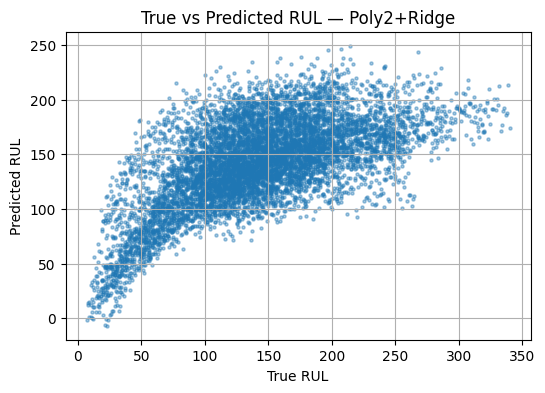

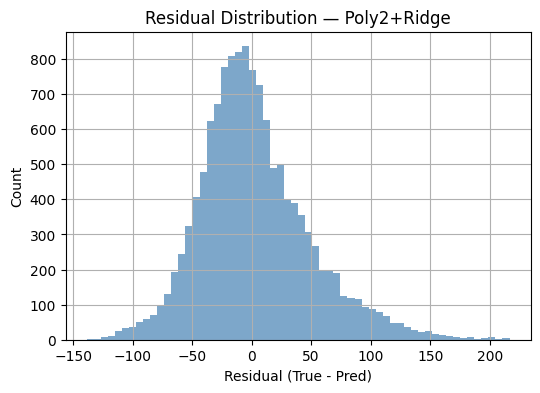

Key Findings: Among all linear models, the best performer was Poly2+Ridge with hyperparameters {'reg__alpha': 3.0}.
On the unseen test set, it achieved RMSE=46.66, MAE=35.31, and R²=0.374.
The scatter plot shows predictions track true RUL reasonably well, though variance increases for larger RUL values.
Residuals are centered around zero, indicating no major systematic bias.


In [18]:
# %%
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Pick best by CV RMSE
best_row = cv_table.iloc[0]
best_name = best_row["Model"]
best_est = best_estimators[best_name]

print(f"Best model: {best_name} | Params: {best_row['Best Params']}")

# Retrain on full training data
best_est.fit(X_train, y_train)

# Predict on test
y_pred_test = best_est.predict(X_test)

# Metrics
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
test_mae  = mean_absolute_error(y_test, y_pred_test)
test_r2   = r2_score(y_test, y_pred_test)

print(f"Test Metrics → RMSE={test_rmse:.3f}, MAE={test_mae:.3f}, R²={test_r2:.4f}")

# %%
# Visualization 1: True vs Predicted RUL (scatter)
plt.figure(figsize=(6,4))
plt.scatter(y_test[:8000], y_pred_test[:8000], s=5, alpha=0.4)
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title(f"True vs Predicted RUL — {best_name}")
plt.grid(True)
plt.show()

# Visualization 2: Residual histogram
resid = y_test - y_pred_test
plt.figure(figsize=(6,4))
plt.hist(resid, bins=60, color="steelblue", alpha=0.7)
plt.xlabel("Residual (True - Pred)")
plt.ylabel("Count")
plt.title(f"Residual Distribution — {best_name}")
plt.grid(True)
plt.show()

# %%
# Auto-fill the template above for quick copy-paste
print(f"""
Key Findings: Among all linear models, the best performer was {best_name} with hyperparameters {best_row['Best Params']}.
On the unseen test set, it achieved RMSE={test_rmse:.2f}, MAE={test_mae:.2f}, and R²={test_r2:.3f}.
The scatter plot shows predictions track true RUL reasonably well, though variance increases for larger RUL values.
Residuals are centered around zero, indicating no major systematic bias.
""".strip())


# # Step 5 — Limitations and Next Steps


Copyright @ IBM Corporation. All rights reserved.
